In [1]:
from config import *
import pandas as pd
import numpy as np
from main_package.bkt_pyKT import convert_df_strings_to_arrays
from main_package.utils import data_path_to_abs_path
from main_package.bkt_pyKT_per_skill import train_bkt as train_bkt_standard, evaluate_bkt
from main_package.bkt_pyKT_per_skill_forget_fix import train_bkt as train_bkt_forget
import json
import matplotlib.pyplot as plt

from pyBKT.models import Model
np.seterr(divide='ignore', invalid='ignore') #pyBKT raises some warnings that I should ignore

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [2]:
def convert_to_pyKT_format(df):
    new_df = df.groupby('user_id').agg({
        'skill_id': list,
        'correct': list,
    }).reset_index()
    new_df = new_df.rename(columns={
        'skill_id': 'concepts',
        'correct': 'responses',
    })
    new_df['concepts'] = new_df['concepts'].apply(np.array)
    new_df['responses'] = new_df['responses'].apply(np.array)
    new_df['is_repeat'] = new_df['concepts'].apply(np.zeros_like)
    return new_df

In [27]:
df_train = pd.read_csv(data_path_to_abs_path("piech/train_df_format.csv"))
#df_train = pd.read_csv(data_path_to_abs_path("assistment/train_v3.csv"))
#df_train['correct'] = df_train['correct'].apply(int)
df_test = pd.read_csv(data_path_to_abs_path("piech/test_df_format.csv"))
#df_test = pd.read_csv(data_path_to_abs_path("assistment/train_v3.csv"))
#df_test['correct'] = df_train['correct'].apply(int)
df_train.head()

,user_id,skill_id,correct
0,0,82,0
1,0,82,0
2,0,82,0
3,0,82,0
4,0,82,0


In [28]:
df_train['skill_id'].unique()

array([ 82,   6,   8,  11,  13,  25,  26,  29,  30,  33,  34,  35,  36,
        37,  44,  45,  46,  48,  55,  79,  80,  81,  86,  89,  99, 103,
       123,  98,  42,   0,   9,  12,  14,  18,  84,   5,   7,  10,  56,
        61,  62,  66, 106,  32,  38,  53,  58,  59,  27,  96,  97,  19,
        20,  21,  41,  47,  67,   1,  49,  78,  87,  88,  91,  92,  93,
        94, 101,  22,  43,  52,   4,  63, 104,  51,  15,  60,  85,  16,
        83,  17,  39,  40, 119,   2,   3,  70,  74,  75, 121,  76,  68,
        54,  24,  31,  50,  65,  90,  69,  23,  71,  72,  73,  77, 114,
       122,  57, 102,  95, 117, 100, 105, 108, 116, 118, 111, 113, 112,
       120, 110, 115, 107, 109,  28])

# trying thins up

In [23]:
skills=['17', '11', '1']
#skills = [0, 1, 2, 3]
#skills = [0, 1]
df_train_filtered = df_train.loc[df_train['skill_id'].isin(skills)]
df_test_filtered = df_test.loc[df_test['skill_id'].isin(skills)]
df_test_filtered

,order_id,user_id,skill_id,problem_id,correct
18,20225581,70759,17,74567,0
19,20225601,70759,17,74564,0
20,20225614,70759,17,74557,1
21,20225623,70759,17,74571,1
22,20225631,70759,17,74553,1
...,...,...,...,...,...
210511,38309690,96282,17,137978,1
210697,38310193,96282,17,93751,1
210698,38310194,96282,17,93725,1
210699,38310195,96282,17,93728,0


In [16]:
df_train

,order_id,user_id,skill_id,problem_id,correct
0,20224085,73963,297,76429,False
1,20224095,73963,297,76430,True
2,20224113,73963,297,76431,True
3,20224123,73963,297,76432,True
4,20224142,73963,297,76433,False
...,...,...,...,...,...
210702,38310198,96282,9_15,135605,True
210703,38310199,96282,9_15,135607,True
210704,38310200,96282,9_15,135601,True
210705,38310201,96282,9_15,135602,True


In [15]:
defaults = {'skill_name': 'skill_id'}
model = Model(seed = 42, num_fits = 5, defaults=defaults)
model.fit(data=df_train_filtered)

In [16]:
print(model.params())

                        value
skill param   class          
0     prior   default 0.76984
      learns  default 0.08341
      guesses default 0.39329
      slips   default 0.15941
      forgets default 0.00000
1     prior   default 0.57253
      learns  default 0.05743
      guesses default 0.11887
      slips   default 0.29897
      forgets default 0.00000


In [17]:
auc = model.evaluate(data=df_test_filtered, metric='auc')
print(f"auc: {auc}")
acc = model.evaluate(data=df_test_filtered, metric='accuracy')
print(f"accuracy: {acc}")

auc: 0.7095949356167635
accuracy: 0.7083333333333334


In [24]:
df_train_f_pyKT = convert_to_pyKT_format(df_train_filtered)
df_test_f_pyKT = convert_to_pyKT_format(df_test_filtered)
df_train_f_pyKT

,user_id,concepts,responses,is_repeat
0,64525,"[17, 17, 17, 17, 17, 17, 11, 11, 11, 11, 11]","[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[, , , , , , , , , , ]"
1,70363,"[11, 11, 11, 11, 11, 11, 11]","[0, 0, 0, 1, 1, 1, 1]","[, , , , , , ]"
2,70677,"[11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 1...","[1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1]","[, , , , , , , , , , , , , , ]"
3,70695,"[11, 11, 11, 11, 11, 11, 11, 11]","[0, 1, 1, 1, 1, 1, 1, 1]","[, , , , , , , ]"
4,70699,"[11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 1...","[1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1]","[, , , , , , , , , , , , , ]"
...,...,...,...,...
599,96294,"[11, 11, 11, 11, 17, 17, 17, 11, 11, 17, 17, 1...","[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, ...","[, , , , , , , , , , , , , , , , ]"
600,96295,"[11, 11, 11, 11, 17, 17, 17, 17, 17, 11, 11, 1...","[1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, ...","[, , , , , , , , , , , , , , , , ]"
601,96296,"[11, 11, 17, 17, 17, 11, 11, 17, 17, 11, 17]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[, , , , , , , , , , ]"
602,96297,"[11, 11, 11, 11, 17, 17, 1, 1, 11, 11, 11, 11,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, ...","[, , , , , , , , , , , , , , , , , , ]"


In [25]:
concepts = np.unique(np.concatenate(df_train_f_pyKT['concepts'].reset_index(drop=True)))
concepts

array(['1', '11', '17'], dtype='<U2')

In [26]:
train_bkt_forget(df_train_f_pyKT)

UFuncTypeError: ufunc 'multiply' did not contain a loop with signature matching types (dtype('<U2'), dtype('int64')) -> None

In [13]:
df_train_f_pyKT.iloc[57]['concepts']

array([0, 0, 1, 1, 1, 1, 1, 1, 1, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3])

In [11]:
df_train_f_pyKT[df_train_f_pyKT['concepts'].apply(lambda concepts: len(np.unique(concepts))) > 1]['concepts']


18     [0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...
51                                 [0, 0, 0, 0, 1, 1, 1]
56            [0, 0, 0, 0, 0, 1, 1, 2, 3, 3, 3, 3, 3, 3]
57     [0, 0, 1, 1, 1, 1, 1, 1, 1, 2, 2, 3, 3, 3, 3, ...
61     [0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...
                             ...                        
728    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, ...
729    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
730    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...
731    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, ...
732    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, ...
Name: concepts, Length: 231, dtype: object

In [13]:
bkt_params

{0: array([0.67611934, 0.39674535, 0.16996486, 0.06755907, 0.01439775]),
 1: array([0.58337513, 0.09736141, 0.35152308, 0.03060902, 0.00442476])}

In [14]:
auc, accuracy = evaluate_bkt(bkt_params, df_test_f_pyKT, None)

number of predicted questions: 2016
auc: 0.7137512671742554
accuracy: 0.7113095238095238


# proper testing

In [14]:
arr_of_skill_list = [
    [1],
    [8],
    [12],
    [0, 2],
    [3, 4],
    [5, 6],
    [21, 22, 23, 24, 25],
    [33],
    [36, 37, 38],
]
defaults = {'skill_name': 'skill_id'}

## BKT

In [103]:
results = {
    "pyBKT": {
        "auc": [],
        "accuracy": [],
    },
    "myBKT": {
        "auc": [],
        "accuracy": [],
    },
}

for skills in arr_of_skill_list:
    # ARRANGE
    df_train_filtered = df_train.loc[df_train['skill_id'].isin(skills)]
    df_test_filtered = df_test.loc[df_test['skill_id'].isin(skills)]
    df_train_f_pyKT = convert_to_pyKT_format(df_train_filtered)
    df_test_f_pyKT = convert_to_pyKT_format(df_test_filtered)
    model = Model(seed = 42, num_fits = 1, defaults=defaults)
    initial_guess =  [0.4, 0.2, 0.08, 0.1] # no forgetting

    # ACT
    print(f"training starts for skills: {skills}")

    #pyBKT
    model.fit(data=df_train_filtered)
    auc_pyBKT = model.evaluate(data=df_test_filtered, metric='auc')
    accuracy_pyBKT = model.evaluate(data=df_test_filtered, metric='accuracy')

    results['pyBKT']['auc'].append(auc_pyBKT)
    results['pyBKT']['accuracy'].append(accuracy_pyBKT)

    print(f'pyBKT results: auc: {auc_pyBKT}, accuracy: {accuracy_pyBKT}')

    #my BKT
    bkt_params = train_bkt_standard(df_train_f_pyKT, initial_guess)
    auc_my, accuracy_my = evaluate_bkt(bkt_params, df_test_f_pyKT, None)

    results['myBKT']['auc'].append(auc_my)
    results['myBKT']['accuracy'].append(accuracy_my)

    print(f'my BKT results: auc: {auc_my}, accuracy: {accuracy_my}')


training starts for skills: [1]
pyBKT results: auc: 0.6915214800522105, accuracy: 0.6630434782608695
concept: 1
training time was: 0m 5s
optimized by: L-BFGS-B
bkt_params
{1: array([0.57270709, 0.10824737, 0.35307137, 0.02605651])}
number of predicted questions: 1196
auc: 0.6902474320413143
accuracy: 0.6663879598662207
my BKT results: auc: 0.6902474320413143, accuracy: 0.6663879598662207
training starts for skills: [8]
pyBKT results: auc: 0.670372709344324, accuracy: 0.6472545757071547
concept: 8
training time was: 0m 6s
optimized by: L-BFGS-B
bkt_params
{8: array([0.73671676, 0.03717081, 0.34642673, 0.09968976])}
number of predicted questions: 601
auc: 0.6706275344013828
accuracy: 0.64891846921797
my BKT results: auc: 0.6706275344013828, accuracy: 0.64891846921797
training starts for skills: [12]
pyBKT results: auc: 0.6004866929070373, accuracy: 0.5807067812798472
concept: 12
training time was: 0m 5s
optimized by: L-BFGS-B
bkt_params
{12: array([6.33848955e-01, 3.56130500e-01, 4.50687

In [105]:
with open('bkt_validations/bkt_result.json', 'w') as f:
  json.dump(results, f, indent=4)

## BKT with forgetting

In [24]:
defaults = {'skill_name': 'skill_id'}

results_forgetting = {
    "pyBKT": {
        "auc": [],
        "accuracy": [],
    },
    "myBKT": {
        "auc": [],
        "accuracy": [],
    },
}

for skills in arr_of_skill_list:
    # ARRANGE
    df_train_filtered = df_train.loc[df_train['skill_id'].isin(skills)].reset_index(drop=True)
    df_test_filtered = df_test.loc[df_test['skill_id'].isin(skills)].reset_index(drop=True)
    df_train_f_pyKT = convert_to_pyKT_format(df_train_filtered)
    df_test_f_pyKT = convert_to_pyKT_format(df_test_filtered)
    model = Model(seed = 42, num_fits = 1, defaults=defaults)

    # ACT
    print(f"training starts for skills: {skills}")

    #pyBKT
    model.fit(data=df_train_filtered, forgets=True)
    auc_pyBKT = model.evaluate(data=df_test_filtered, metric='auc')
    accuracy_pyBKT = model.evaluate(data=df_test_filtered, metric='accuracy')

    results_forgetting['pyBKT']['auc'].append(auc_pyBKT)
    results_forgetting['pyBKT']['accuracy'].append(accuracy_pyBKT)

    print(f'pyBKT results: auc: {auc_pyBKT}, accuracy: {accuracy_pyBKT}')

    #my BKT
    bkt_params = train_bkt_forget(df_train_f_pyKT)
    auc_my, accuracy_my = evaluate_bkt(bkt_params, df_test_f_pyKT, None)

    results_forgetting['myBKT']['auc'].append(auc_my)
    results_forgetting['myBKT']['accuracy'].append(accuracy_my)

    print(f'my BKT results: auc: {auc_my}, accuracy: {accuracy_my}')

training starts for skills: [1]
pyBKT results: auc: 0.7025793087792975, accuracy: 0.6705685618729097
concept: 1
training time was: 0m 11s
optimized by: L-BFGS-B
bkt_params
{1: array([0.58337547, 0.09736135, 0.35152312, 0.03060899, 0.00442475])}
number of predicted questions: 1196
auc: 0.7028942738777594
accuracy: 0.669732441471572
my BKT results: auc: 0.7028942738777594, accuracy: 0.669732441471572
training starts for skills: [8]
pyBKT results: auc: 0.6712368986682621, accuracy: 0.6472545757071547
concept: 8
training time was: 0m 6s
optimized by: L-BFGS-B
bkt_params
{8: array([0.7448954 , 0.00198325, 0.32348661, 0.14815387, 0.02395593])}
number of predicted questions: 601
auc: 0.6717964058587604
accuracy: 0.5973377703826955
my BKT results: auc: 0.6717964058587604, accuracy: 0.5973377703826955
training starts for skills: [12]
pyBKT results: auc: 0.6018939976984703, accuracy: 0.5797516714422158
concept: 12
training time was: 0m 3s
optimized by: L-BFGS-B
bkt_params
{12: array([2.89087844e

In [25]:
with open('bkt_validations/bkt_result_forget_fix.json', 'w') as f:
  json.dump(results_forgetting, f, indent=4)

# Plotting

In [26]:
dataset_sizes = []
for skills in arr_of_skill_list:
    df_train_filtered = df_train.loc[df_train['skill_id'].isin(skills)]
    df_test_filtered = df_test.loc[df_test['skill_id'].isin(skills)]
    dataset_sizes.append(len(df_train_filtered) + len(df_test_filtered))
dataset_sizes

[6208, 2938, 4867, 5761, 3754, 10662, 7458, 8539, 9757]

In [108]:
'''
dataset_sizes = []
for skill in range(120):
    skills = [skill]
    df_train_filtered = df_train.loc[df_train['skill_id'].isin(skills)]
    df_test_filtered = df_test.loc[df_test['skill_id'].isin(skills)]
    dataset_sizes.append((skill, len(df_train_filtered) + len(df_test_filtered)))
dataset_sizes
'''

"\ndataset_sizes = []\nfor skill in range(120):\n    skills = [skill]\n    df_train_filtered = df_train.loc[df_train['skill_id'].isin(skills)]\n    df_test_filtered = df_test.loc[df_test['skill_id'].isin(skills)]\n    dataset_sizes.append((skill, len(df_train_filtered) + len(df_test_filtered)))\ndataset_sizes\n"

In [27]:
with open('bkt_validations/bkt_result.json', 'r') as f:
    bkt_results = json.load(f)

with open('bkt_validations/bkt_result_forget.json', 'r') as f:
    bkt_results_forget = json.load(f)

with open('bkt_validations/bkt_result_forget_fix.json', 'r') as f:
    bkt_results_forget_fix = json.load(f)

model_names = ['pyBKT', 'myBKT']
labels = {
    'pyBKT': 'pyBKT',
    'myBKT': 'my code',
}
measures = ['auc', 'accuracy']

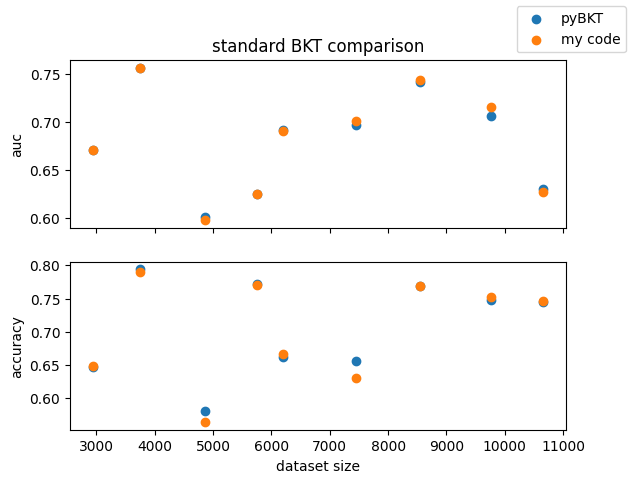

In [110]:
fig, axs = plt.subplots(nrows=2, ncols=1, sharex=True)
for row in range(2):
    ax = axs[row]
    measure = measures[row]
    ax.set_ylabel(measure)
    for model_name in model_names:
        ax.scatter(dataset_sizes, bkt_results[model_name][measure], label=labels[model_name])

axs[0].set_title('standard BKT comparison')
axs[1].set_xlabel('dataset size')
fig.legend(labels.values())
plt.show()
        

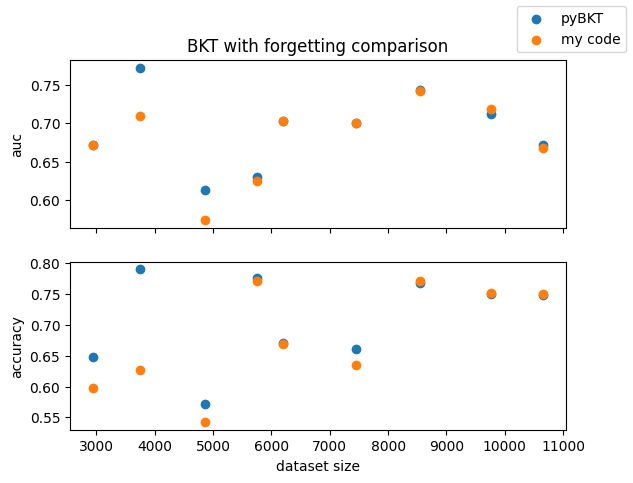

In [28]:
fig, axs = plt.subplots(nrows=2, ncols=1, sharex=True)
for row in range(2):
    ax = axs[row]
    measure = measures[row]
    ax.set_ylabel(measure)
    for model_name in model_names:
        ax.scatter(dataset_sizes, bkt_results_forget[model_name][measure], label=labels[model_name])

axs[0].set_title('BKT with forgetting comparison')
axs[1].set_xlabel('dataset size')
fig.legend(labels.values())
plt.show()

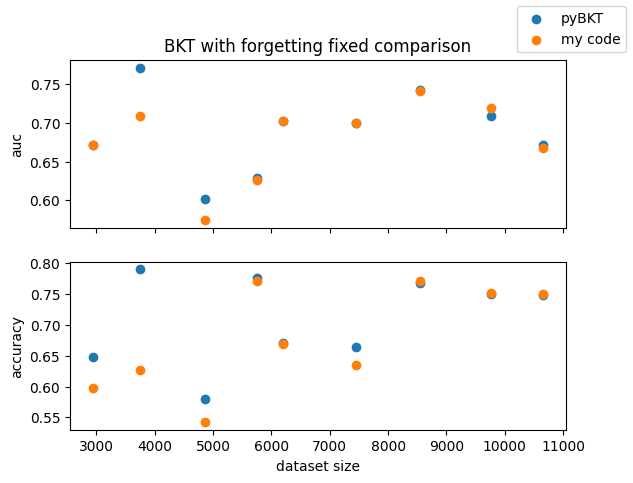

In [29]:
fig, axs = plt.subplots(nrows=2, ncols=1, sharex=True)
for row in range(2):
    ax = axs[row]
    measure = measures[row]
    ax.set_ylabel(measure)
    for model_name in model_names:
        ax.scatter(dataset_sizes, bkt_results_forget_fix[model_name][measure], label=labels[model_name])

axs[0].set_title('BKT with forgetting fixed comparison')
axs[1].set_xlabel('dataset size')
fig.legend(labels.values())
plt.show()

In [7]:
# bkt forget fix
df_example_1 = pd.DataFrame(data={
    'concepts': [np.array([0, 0, 1, 0, 1, 1, 0])],
    'responses': [np.array([1, 0, 1, 0, 1, 0, 1])],
    'is_repeat': [np.array([0, 0, 0, 0, 0, 0, 0])],
    #'sequence_positions':[np.array([0, 1, 2, 3, 4, 5, 6])],
})

df_example_2 = pd.DataFrame(data={
    'concepts': [np.array([0, 0, 0, 0, 1, 1, 1])],
    'responses': [np.array([1, 0, 0, 1, 1, 1, 0])],
    'is_repeat': [np.array([0, 0, 0, 0, 0, 0, 0])],
    #'sequence_positions':[[0, 1, 2, 3, 4, 5, 6]],
})

bkt_params_ex1 = train_bkt_forget(df_example_1)
bkt_params_ex1

concept: 0
bkt_student_interaction
i: 0
p_knows_concept_prior: 0.4
i: 1
num_exercises_in_between: 1
p_knows_concept_prior: 0.7709016393442624
i: 2
num_exercises_in_between: 2
p_knows_concept_prior: 0.3200969080444386
i: 3
num_exercises_in_between: 3
p_knows_concept_prior: 0.13629464500388103
bkt_student_interaction
i: 0
p_knows_concept_prior: 0.40000001
i: 1
num_exercises_in_between: 1
p_knows_concept_prior: 0.7709016462285004
i: 2
num_exercises_in_between: 2
p_knows_concept_prior: 0.3200969145216932
i: 3
num_exercises_in_between: 3
p_knows_concept_prior: 0.13629464611993578
bkt_student_interaction
i: 0
p_knows_concept_prior: 0.4
i: 1
num_exercises_in_between: 1
p_knows_concept_prior: 0.7709016310831768
i: 2
num_exercises_in_between: 2
p_knows_concept_prior: 0.3200969023488747
i: 3
num_exercises_in_between: 3
p_knows_concept_prior: 0.1362946444912556
bkt_student_interaction
i: 0
p_knows_concept_prior: 0.4
i: 1
num_exercises_in_between: 1
p_knows_concept_prior: 0.770901637548374
i: 2
nu

{0: array([9.99900000e-01, 3.33322231e-01, 1.00000000e-04, 2.84646883e-01,
        9.99900000e-01]),
 1: array([9.99900000e-01, 4.99999996e-01, 1.00000000e-04, 1.00000000e-04,
        6.69079036e-01])}

In [8]:
bkt_params_ex2 = train_bkt_forget(df_example_2)
bkt_params_ex2

concept: 0
bkt_student_interaction
i: 0
p_knows_concept_prior: 0.4
i: 1
num_exercises_in_between: 1
p_knows_concept_prior: 0.7709016393442624
i: 2
num_exercises_in_between: 1
p_knows_concept_prior: 0.3233302101458975
i: 3
num_exercises_in_between: 1
p_knows_concept_prior: 0.13963273273726817
bkt_student_interaction
i: 0
p_knows_concept_prior: 0.40000001
i: 1
num_exercises_in_between: 1
p_knows_concept_prior: 0.7709016462285004
i: 2
num_exercises_in_between: 1
p_knows_concept_prior: 0.323330216688579
i: 3
num_exercises_in_between: 1
p_knows_concept_prior: 0.13963273389694658
bkt_student_interaction
i: 0
p_knows_concept_prior: 0.4
i: 1
num_exercises_in_between: 1
p_knows_concept_prior: 0.7709016310831768
i: 2
num_exercises_in_between: 1
p_knows_concept_prior: 0.32333020439280274
i: 3
num_exercises_in_between: 1
p_knows_concept_prior: 0.13963273220228933
bkt_student_interaction
i: 0
p_knows_concept_prior: 0.4
i: 1
num_exercises_in_between: 1
p_knows_concept_prior: 0.770901637548374
i: 2
n

{0: array([9.99900000e-01, 3.33266676e-01, 1.00000000e-04, 9.99900000e-01,
        9.99900000e-01]),
 1: array([9.99900000e-01, 3.32122180e-01, 1.00000000e-04, 1.00000000e-04,
        6.67850261e-01])}

In [ ]:
{0: array([9.99900000e-01, 3.33322231e-01, 1.00000000e-04, 2.84646883e-01,
        9.99900000e-01]),
 1: array([9.99900000e-01, 4.99999996e-01, 1.00000000e-04, 1.00000000e-04,
        6.69079036e-01])}

{0: array([9.99900000e-01, 3.33266676e-01, 1.00000000e-04, 9.99900000e-01,
        9.99900000e-01]),
 1: array([9.99900000e-01, 3.32122180e-01, 1.00000000e-04, 1.00000000e-04,
        6.67850261e-01])}
